In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import TensorDataset, DataLoader

seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#paths
local_tr_p = 'data\localization_train.pt'
local_v_p = 'data\localization_val.pt'
local_tes_p = 'data\localization_test.pt' 

#datasets
loc_train = torch.load(local_tr_p)
loc_val = torch.load(local_v_p)
loc_test = torch.load(local_tes_p)


### Section 2

#### Data analysis

Shape and type of data

In [2]:
sample, label = loc_train[0]
print('Size of the training dataset      : %d' %len(loc_train))
print('Shape of the sample image       :', sample.shape)
print('Type of the sample        :', sample.dtype)
print('Shape of label     :', label.shape)
print("label of sample image: ", label)
print('Type of the label       :', label.dtype)


Size of the training dataset      : 59400
Shape of the sample image       : torch.Size([1, 48, 60])
Type of the sample        : torch.float32
Shape of label     : torch.Size([6])
label of sample image:  tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])
Type of the label       : torch.float32


Plot 4 images of each class

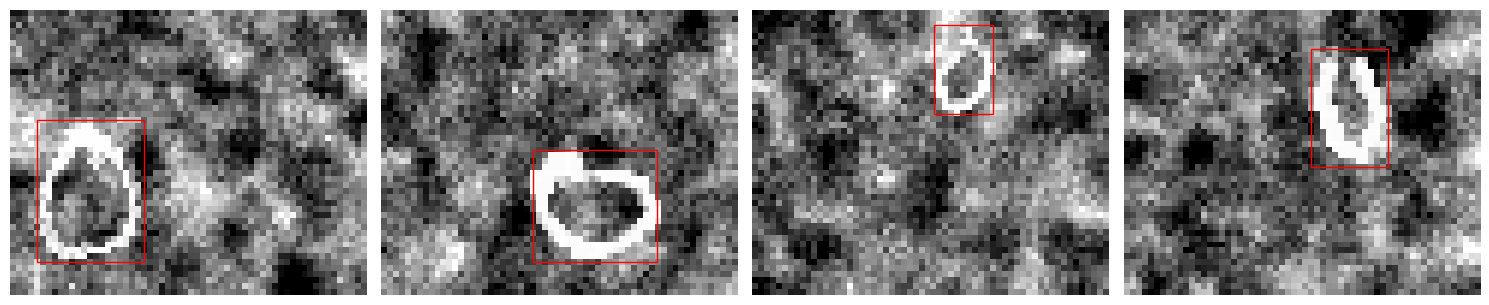

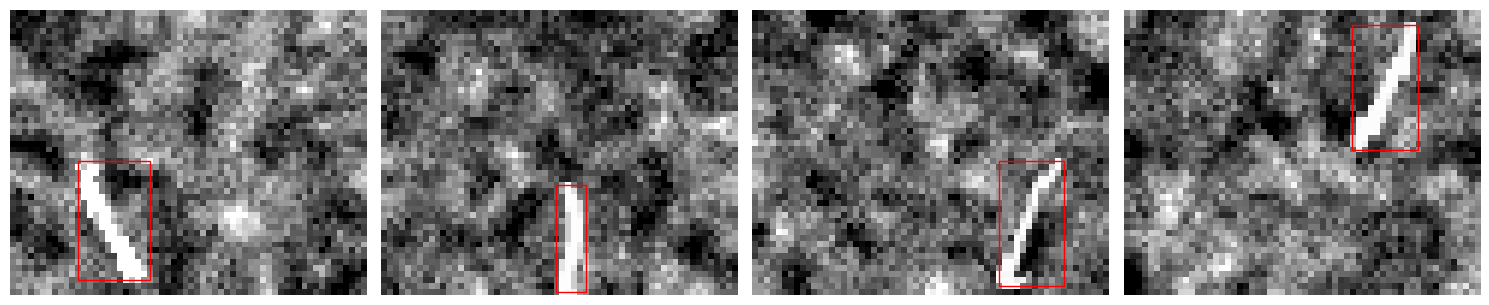

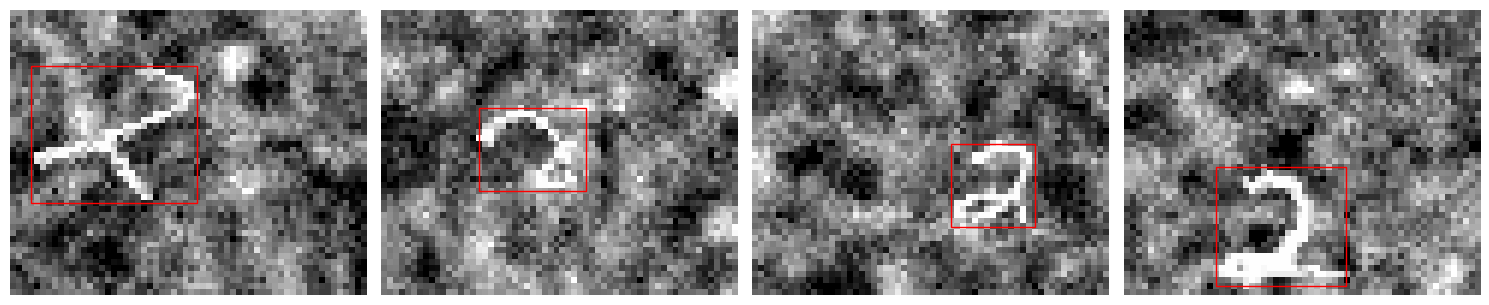

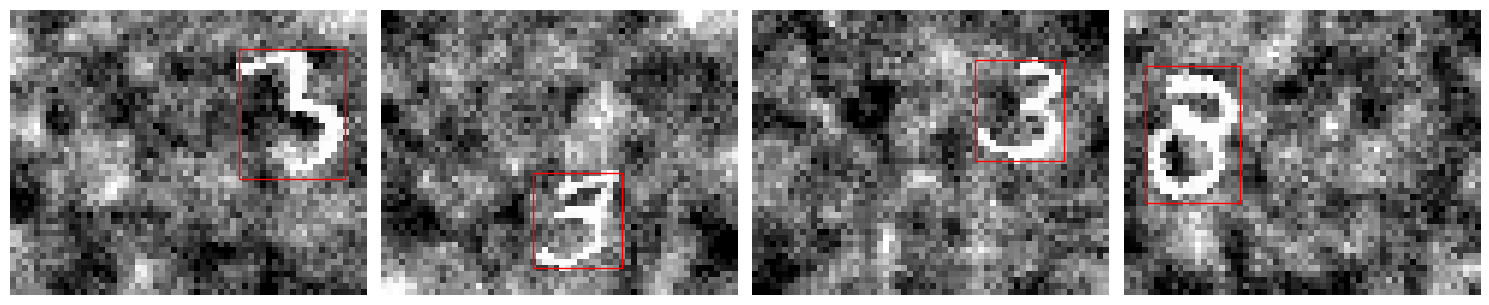

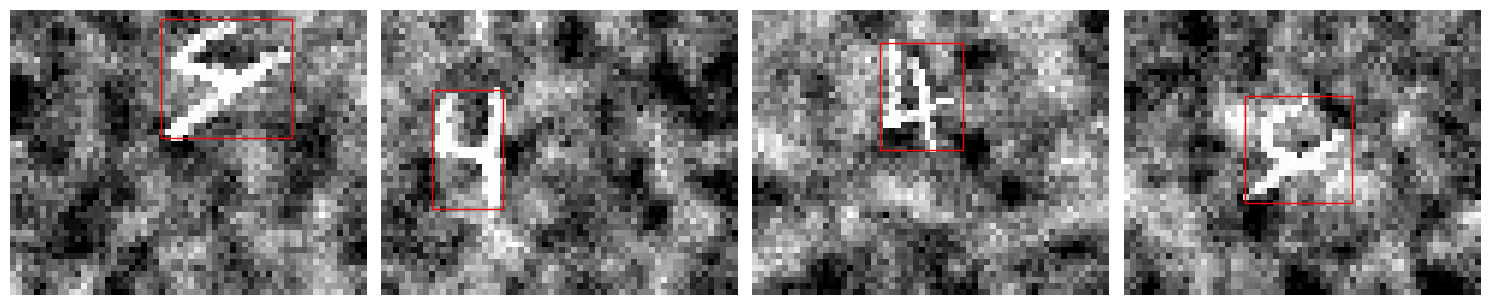

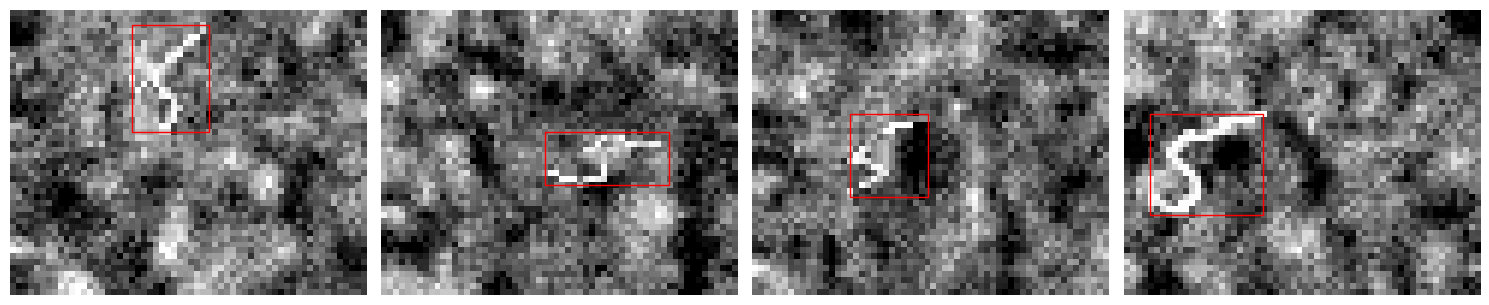

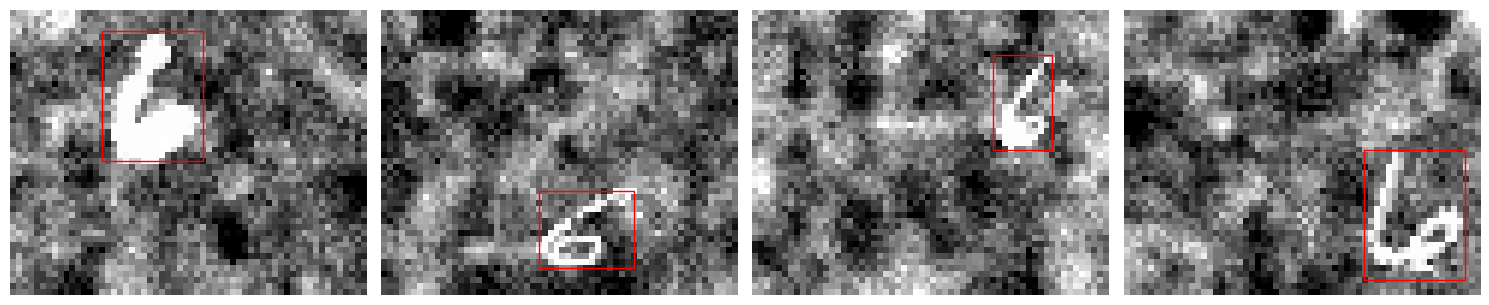

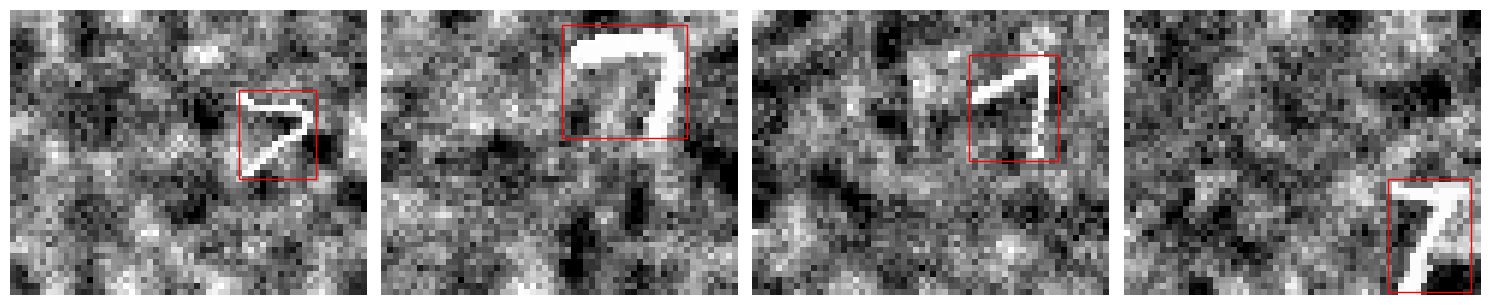

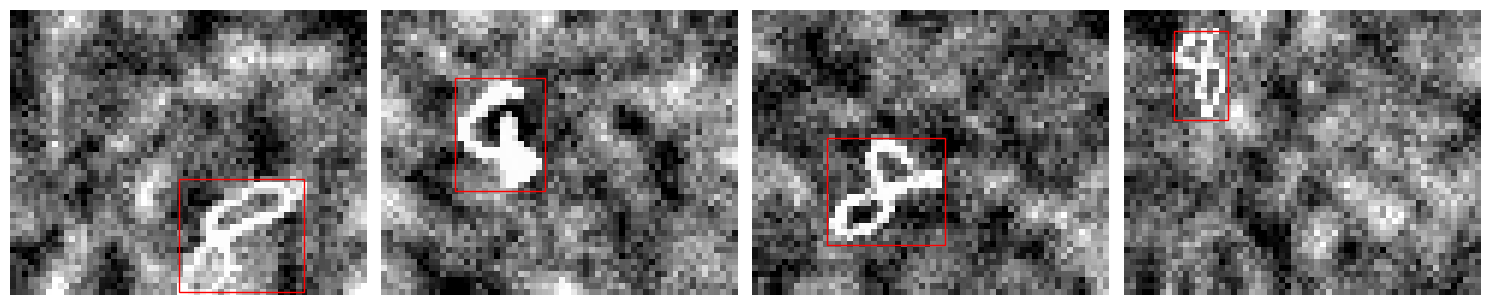

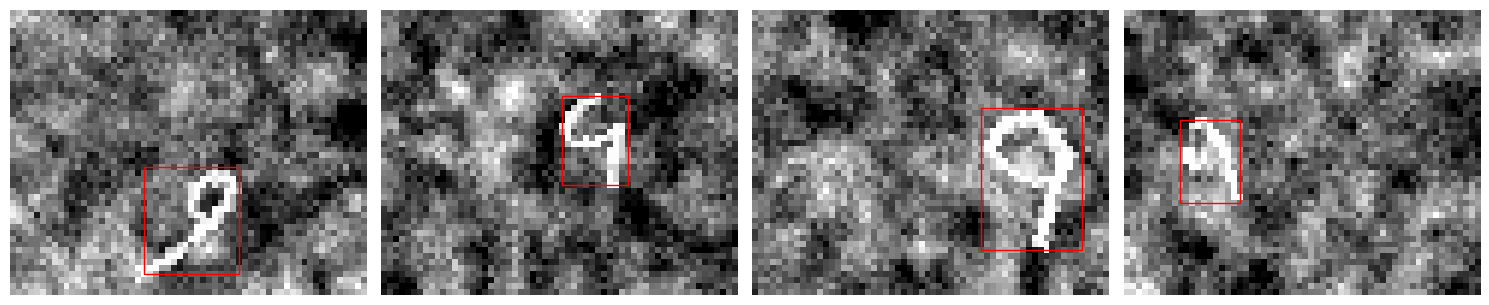

In [3]:
def plot_instances(loc_train, target_class, n_instances=4):
    fig, axes = plt.subplots(nrows=1, ncols=n_instances, figsize=(15, 5), tight_layout=True)
    imgs_with_bbox = [(img, label) for (img, label) in loc_train if label[5] == target_class and label[0].item() != 0]
    selected_imgs_with_bbox = imgs_with_bbox[:n_instances]

    for j, (img, label) in enumerate(selected_imgs_with_bbox):
        ax = axes[j]

        ax.imshow(img.permute(1, 2, 0).numpy(), cmap='gray')

        #Normalize bounding box coordinates to image dimensions
        img_height, img_width = 48, 60
        x_center, y_center, w, h = label[1]*img_width, label[2]*img_height, label[3]*img_width, label[4]*img_height
        rect = patches.Rectangle((x_center - w / 2, y_center - h / 2), w, h, linewidth=1, edgecolor='r', facecolor='none')
        
        ax.add_patch(rect)
        ax.axis('off')
    
    plt.show()


n_classes = len(set([int(label[5].item()) for _, label in loc_train if label[0].item() != 0]))
for i in range(n_classes):
    plot_instances(loc_train, i, n_instances=4)

Class distribution


Number of classes:               10
Biggest class:   1   occurrence:  6075
Smallest class:  5   occurrence:  4889
Number of images with no object:  5400


Text(0.5, 0, 'Labels')

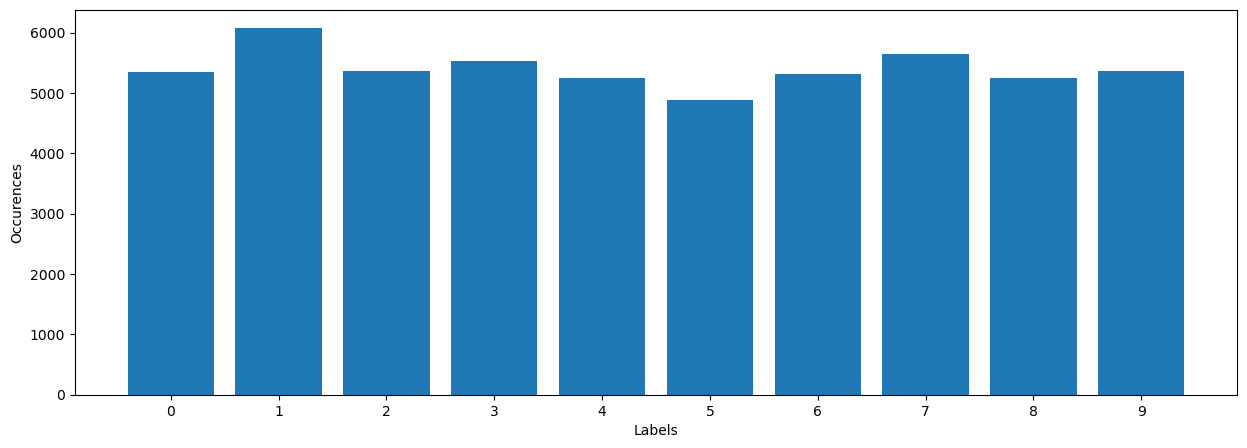

In [4]:
#Check number of images with objects in them
counter = Counter([int(label[5]) for _, label in loc_train if label[0].item() != 0]) 
#Check number of no object images
no_img = Counter([int(label[5]) for _, label in loc_train if label[0].item() == 0]) 

n_tot = counter.total()
    
n_classes = len(counter)
    
c = counter.most_common()    


print('\nNumber of classes:               %d' %len(c))
print("Biggest class:   %d   occurrence:  %d" %(c[0][0], c[0][1]))
print("Smallest class:  %d   occurrence:  %d" %(c[-1][0], c[-1][1]))
print("Number of images with no object: ", no_img[1])

n_classes = len(counter)
    
labels = np.arange(n_classes)
labels = [x[0] for x in c]
occurrences = [counter[l] for l in labels]
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(labels, occurrences, tick_label=labels)
ax.set_ylabel("Occurences")
ax.set_xlabel("Labels")

#### Normalize data

In [5]:
imgs_train = torch.cat([img for img, _ in loc_train])

normalizer = transforms.Normalize(
    imgs_train.mean(dim=(0, 1, 2)), 
    imgs_train.std(dim=(0, 1, 2))
    )

transform = transforms.Compose([
    normalizer 
])

#Normalize data
loc_train_norm = [(transform(img), label) for img, label in loc_train]
loc_val_norm = [(transform(img), label) for img, label in loc_val]
loc_test_norm = [(transform(img), label) for img, label in loc_test]


#Rename back
loc_train = loc_train_norm
loc_val=loc_val_norm
loc_test = loc_test_norm


#### Convolutional model

In [6]:
class LocalizationCNN(nn.Module):
    def __init__(self):
        super(LocalizationCNN, self).__init__()
        #Input image dimensions: 48x60
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1_cls = nn.Linear(64 * 6 * 7, 128) #7.5 gets rounded down to 7
        self.fc2_cls = nn.Linear(128, 10)

        self.fc_detection = nn.Linear(128, 1) 
        
        self.fc1_bb = nn.Linear(64 * 6 * 7, 128)  
        self.fc2_bb = nn.Linear(128, 4) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        #Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 6 * 7)  

        x_cls = F.relu(self.fc1_cls(x))
        class_output = self.fc2_cls(x_cls)

        object_presence = torch.sigmoid(self.fc_detection(x_cls))

        x_bb = F.relu(self.fc1_bb(x))
        bb_output = torch.sigmoid(self.fc2_bb(x_bb))

        #cat all object presence, bb, and class probabilities
        output = torch.cat((object_presence, bb_output, class_output), dim=1)

        return output

Loss function

In [7]:
class LocalizationLoss(nn.Module):
    def __init__(self):
        super(LocalizationLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        pred_detection = predictions[:, 0]
        pred_bb = predictions[:, 1:5]
        pred_classes = predictions[:, 5:]

        target_detection = targets[:, 0]
        target_bb = targets[:, 1:5]
        target_classes = targets[:, 5].long()

        #Compute detection loss (LA)
        loss_a = self.bce_loss(pred_detection, target_detection)

        #Apply masks for images with objects to compute LB and LC
        mask = target_detection > 0.5  #Images with objects
        object_count = mask.sum().item()  #Number of images with objects

        #Compute localization loss (LB) only for images with objects
        loss_b = self.mse_loss(pred_bb[mask], target_bb[mask]) / object_count if object_count > 0 else 0

        #Compute classification loss (LC) only for images with objects
        loss_c = self.ce_loss(pred_classes[mask], target_classes[mask]) if object_count > 0 else 0

        #Combine losses
        total_loss = loss_a + loss_b + loss_c
        return total_loss

Training and evaluating functions

In [8]:
def train_and_evaluate_model(model, train_loader, val_loader, epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print("Training on device: ", device)
    model.to(device)

    loss_function = LocalizationLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    val_losses = []
    train_losses = []


    #Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()


            running_loss += loss.item()
        #Now evaluate on the validation set
        model.eval()  
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, = images.to(device)
                labels  = labels.to(device)
                outputs = model(images)
                loss = loss_function(outputs, labels)

                val_running_loss += loss.item()
        
        val_losses.append(val_running_loss / len(val_loader))
        train_losses.append(running_loss/len(train_loader))

        print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_running_loss / len(val_loader)}")

    print('Finished Training')
    val_acc, val_iou = evaluate_model(model, val_loader)
    val_performance = (val_iou + val_acc) / 2
    return val_acc, val_iou, val_performance, val_losses, train_losses

def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()
    
    total, correct = 0, 0
    sum_iou = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs[:, 5:], 1)  #Get the class predictions
            true_classes = labels[:, 5].long()  #True class labels
            
            #Calculate classification accuracy
            total += labels.size(0)
            correct += (predicted == true_classes).sum().item()

            #Calculate IoU for bounding boxes
            pred_boxes = outputs[:, 1:5]  #Predicted bounding boxes
            true_boxes = labels[:, 1:5]  #True bounding boxes
            iou = bbox_iou(pred_boxes, true_boxes)
            sum_iou += iou.sum().item()
    
    accuracy = correct / total
    mean_iou = sum_iou / total
    return accuracy, mean_iou


def bbox_iou(pred_boxes, true_boxes):
    inter_rect_x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    inter_rect_y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    inter_rect_x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    inter_rect_y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])
    

    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    

    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0] + 1) * (pred_boxes[:, 3] - pred_boxes[:, 1] + 1)
    true_area = (true_boxes[:, 2] - true_boxes[:, 0] + 1) * (true_boxes[:, 3] - true_boxes[:, 1] + 1)
    
    union_area = pred_area + true_area - inter_area

    iou = inter_area / union_area
    
    return iou


#### Training

Training several models and choosing best one based on perfomance on validation data

In [9]:
#Global params
val_loader = torch.utils.data.DataLoader(loc_val, batch_size=1, shuffle=True)
epochs = 20


batch_size = [32, 64, 128]

lr_list = [0.1, 0.01, 0.001]

best_val_p = 0
best_model = None
best_batch = 0
best_optim = ''
best_lr = 0
best_v_acc = 0
best_iou = 0


for bs in batch_size:
    for lr in lr_list:
        print(f"Training model with bach size: {bs}, and learning rate: {lr} ")
        model = LocalizationCNN() 
        train_loader = torch.utils.data.DataLoader(loc_train, batch_size=bs, shuffle=True)
        learning_rate = lr
        val_acc, val_iou, val_per, val_losses, train_losses = train_and_evaluate_model(model, train_loader, val_loader, epochs, learning_rate)
        print(f"Model: validation accuracy:{val_acc} , validation iou: {val_iou} and mean performance: {val_per}")
        if val_per > best_val_p:
            best_batch = bs
            best_lr = learning_rate
            best_v_acc = val_acc
            best_iou = val_iou
            best_val_p = val_per
            best_v_losses = val_losses
            best_t_losses = train_losses
            best_model = model


print(f"Final best model is a model with bach size: {best_batch}, and learning rate: {best_lr} ")
print()
print(f"Best model: validation accuracy:{best_v_acc:.2f} , validation iou: {best_iou:.2f} and mean performance: {best_val_p:.2f}")




Training model with bach size: 32, and learning rate: 0.1 
Training on device:  cuda
Epoch 1, Training Loss: 16.024438500468552, Validation Loss: 2.5256928038958346
Epoch 2, Training Loss: 2.719602115191499, Validation Loss: 2.5255608388510615
Epoch 3, Training Loss: 2.719798298118316, Validation Loss: 2.536172859632608
Epoch 4, Training Loss: 2.7193002876698746, Validation Loss: 2.5218974122134123
Epoch 5, Training Loss: 2.7201247107424145, Validation Loss: 2.5306199008045773
Epoch 6, Training Loss: 2.7198868149637727, Validation Loss: 2.530158763220816
Epoch 7, Training Loss: 2.719721198274554, Validation Loss: 2.5272870669581673
Epoch 8, Training Loss: 2.7201118140562155, Validation Loss: 2.5353272171815235
Epoch 9, Training Loss: 2.719950182950169, Validation Loss: 2.52951928005074
Epoch 10, Training Loss: 2.7196277586054145, Validation Loss: 2.518221968376275
Epoch 11, Training Loss: 2.720007082307987, Validation Loss: 2.522071229580677
Epoch 12, Training Loss: 2.719938688529841, 

Plotting loss over epochs

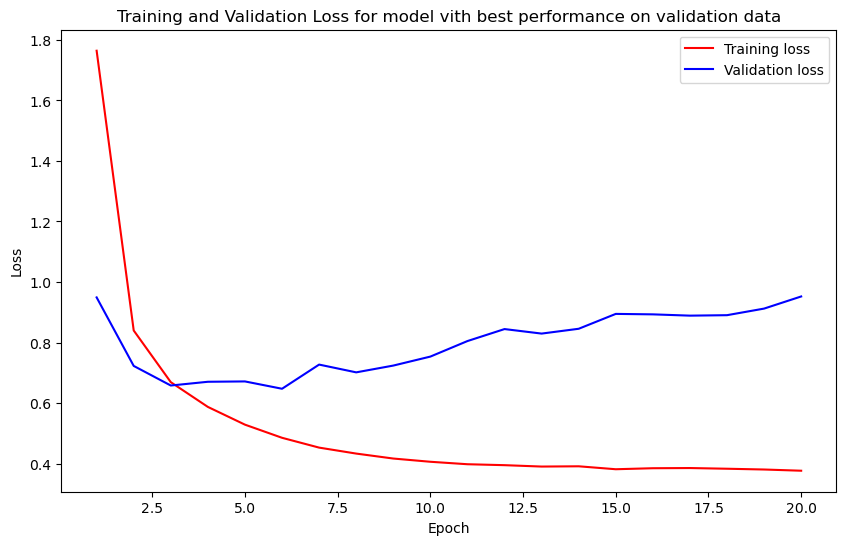

In [10]:
#Plotting losses of best model
plt.figure(figsize=(10, 6))
epochs_plot = range(1, len(best_t_losses) + 1)
plt.plot(epochs_plot, best_t_losses, 'r-', label='Training loss')
plt.plot(epochs_plot, best_v_losses, 'b-', label='Validation loss')
plt.title('Training and Validation Loss for model vith best performance on validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot some images with their bounding box

In [13]:
def plot_bbox_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def plot_images_with_boxes(model, data_loader, num_images=5):
    model.eval() 
    device = next(model.parameters()).device  
    
    img_height, img_width = 48, 60
    
    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
    plotted_images = 0
    for batch_idx, (images, labels) in enumerate(data_loader):
        if plotted_images >= num_images:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        for img_idx in range(images.shape[0]):
            
            if labels[img_idx, 0].item() <= 0.5: #Skip images without objects
                continue

            ax = axs[plotted_images]
            img = images[img_idx].cpu().numpy().transpose((1, 2, 0))  
            ax.imshow(img, cmap='gray')
            
            #True bounding box
            true_bbox = labels[img_idx, 1:5].cpu().numpy() 

            true_x, true_y, true_w, true_h = true_bbox[0]*img_width, true_bbox[1]*img_height, true_bbox[2]*img_width, true_bbox[3]*img_height
            true_box_plot = [true_x-true_w/2, true_y-true_h/2, true_x+true_w/2, true_y+true_h/2]


            true_rect = patches.Rectangle((true_x-true_w/2, true_y-true_h/2), true_w, true_h, linewidth=2, edgecolor='g', facecolor='none', label = 'true_bb')
            ax.add_patch(true_rect)
            
            #Predicted bounding box
            pred_bbox = outputs[img_idx, 1:5].detach().cpu().numpy()

            pred_x, pred_y, pred_w, pred_h = pred_bbox[0]*img_width, pred_bbox[1]*img_height, pred_bbox[2]*img_width, pred_bbox[3]*img_height
            pred_box_plot = [pred_x-pred_w/2, pred_y-pred_h/2, pred_x+pred_w/2, pred_y+pred_h/2]
            pred_rect = patches.Rectangle((pred_x-pred_w/2, pred_y-pred_h/2), pred_w, pred_h, linewidth=2, edgecolor='r', facecolor='none', label = 'predicted_bb')
            ax.add_patch(pred_rect)
            
            true_label = labels[img_idx, 5].cpu().item()
            pred_label = outputs[img_idx, 5:].detach().cpu().max(0)[1].item()
            bb_iou = plot_bbox_iou(true_box_plot, pred_box_plot)
            ax.set_title(f"True: {true_label}, Pred: {pred_label}, IOU: {bb_iou:.2f}")
            
            ax.axis('off')
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)

            plotted_images += 1  
            
            if plotted_images >= num_images:
                break

    plt.show()



Best model train accuracy: 0.95 , train iou: 0.83 and train mean performance: 0.89


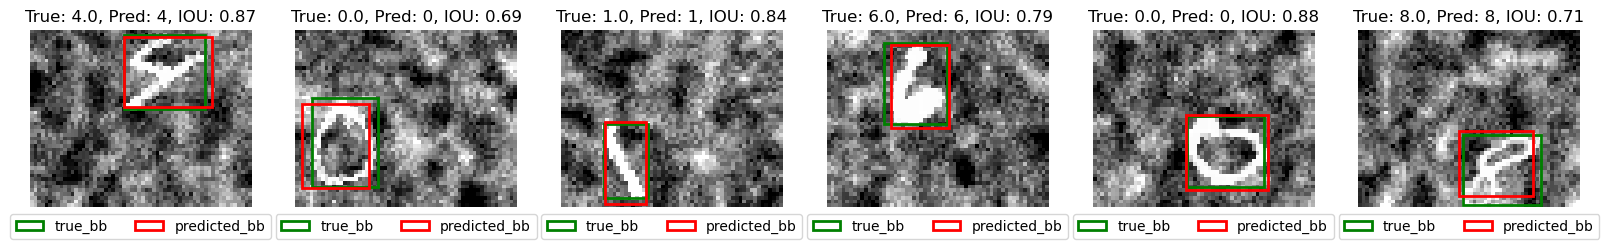

In [14]:
#Evaluate the model on training
train_loader = torch.utils.data.DataLoader(loc_train, batch_size=1, shuffle=False)

train_acc, train_iou  = evaluate_model(best_model, train_loader)

train_p = (train_acc + train_iou) / 2

print(f"Best model train accuracy: {train_acc:.2f} , train iou: {train_iou:.2f} and train mean performance: {train_p:.2f}")

plot_images_with_boxes(best_model, train_loader, num_images=6)


Best model val accuracy: 0.87 , val iou: 0.80 and val mean performance: 0.84


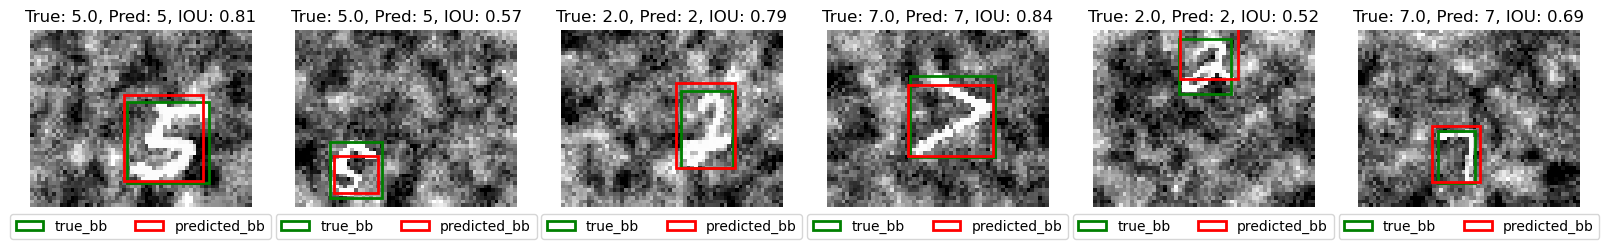

In [15]:
#Evaluate the model on val
val_loader  = torch.utils.data.DataLoader(loc_val, batch_size=1, shuffle=False)

val_acc, val_iou  = evaluate_model(best_model, val_loader)

val_p = (val_acc + val_iou) / 2

print(f"Best model val accuracy: {val_acc:.2f} , val iou: {val_iou:.2f} and val mean performance: {val_p:.2f}")

plot_images_with_boxes(best_model, val_loader, num_images=6)

Evaluate the chosen model on test data


Best model test accuracy: 0.88 , test iou: 0.80 and test mean performance: 0.84


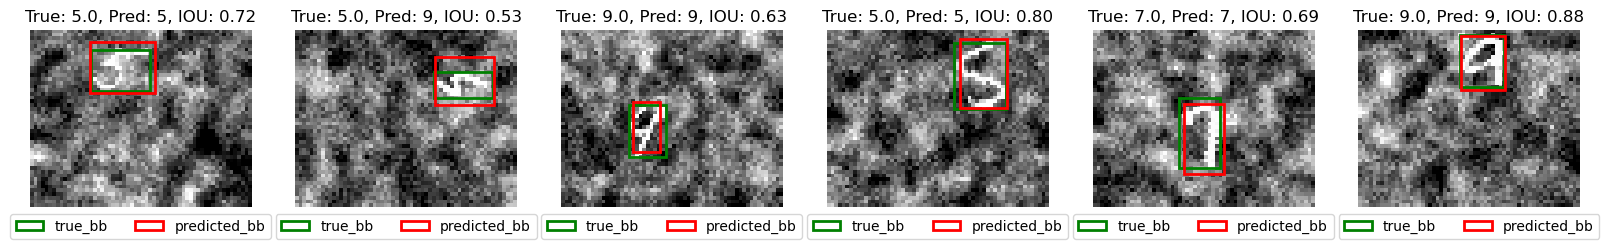

In [16]:
test_loader = torch.utils.data.DataLoader(loc_test, batch_size=1, shuffle=False)

test_acc, test_iou  = evaluate_model(best_model, test_loader)

test_p = (test_acc + test_iou) / 2

print(f"Best model test accuracy: {test_acc:.2f} , test iou: {test_iou:.2f} and test mean performance: {test_p:.2f}")

plot_images_with_boxes(best_model, test_loader, num_images=6)

### Section 3

Load prepared dataset and non prepared dataset

In [17]:
#paths for prepared data
detect_tr_p = 'data\detection_train.pt'
detect_v_p = 'data\detection_val.pt'
detect_tes_p = 'data\detection_test.pt' 

#prepared datasets
prepared_train = torch.load(detect_tr_p)
prepared_val = torch.load(detect_v_p)
prepared_test = torch.load(detect_tes_p)


#paths for non prepared data
list_tr_p = 'data\list_y_true_train.pt'
list_v_p = 'data\list_y_true_val.pt'
list_tes_p = 'data\list_y_true_test.pt' 

#non prepared label datasets
lis_train = torch.load(list_tr_p)
lis_val = torch.load(list_v_p)
lis_test = torch.load(list_tes_p)

In [18]:
#Function to convert to (Ntot, Hout, Wout, 6) tensor 
def convert_to_grid_tensors(list_y_true, Hout, Wout):
    Ntot = len(list_y_true)
    grid_tensors = torch.zeros((Ntot, Hout, Wout, 6))
    
    for i, img_tensors in enumerate(list_y_true):
        for obj_tensor in img_tensors:
            pc, x, y, w, h, c = obj_tensor
            #Cell coords
            cell_x = int(x * Wout)
            cell_y = int(y * Hout)

            cell_x = min(Wout - 1, max(0, cell_x))
            cell_y = min(Hout - 1, max(0, cell_y))

            #Convert global bounding box coordinates to local coordinates
            local_x = x * Wout - cell_x
            local_y = y * Hout - cell_y

            local_w = w * Wout
            local_h = h * Hout
            grid_tensors[i, cell_y, cell_x] = torch.tensor([pc, local_x, local_y, local_w, local_h, c])

    return grid_tensors

#Iterate over the datasets and compare elements
def checkDataset(prepared_data, processed_data):
    isEqual = True
    for i, ((images, labels)) in enumerate(processed_data):
        #Extract the corresponding image from the prepared data
        original_image = prepared_data[i][0]
        original_label = prepared_data[i][1]

    #Compare images
        if not torch.equal(images, original_image):
            print(f"Image mismatch at index {i}")
            isEqual = False
            continue
    
    #Compare labels
        if not torch.allclose(labels, original_label, atol=1e-50): #Checks if there is a difference with a small margin of error
            print(f"Label mismatch at index {i}")
            isEqual = False
            continue
    
    if isEqual == True:
        print("Comparison completed, datasets match.")
    
    return isEqual


Hout = 2 #From task desc
Wout = 3 #From task desc

#Convert data to grid tensors
grid_train = convert_to_grid_tensors(lis_train, Hout=Hout, Wout=Wout)
grid_val = convert_to_grid_tensors(lis_val, Hout=Hout, Wout=Wout)
grid_test = convert_to_grid_tensors(lis_test, Hout=Hout, Wout=Wout)


#Get images from our prepared data
images_tr = torch.stack([item[0] for item in prepared_train])
images_v = torch.stack([item[0] for item in prepared_val])
images_te = torch.stack([item[0] for item in prepared_test])


#Create new TensorDatasets that include our processed labels
detect_train = torch.utils.data.TensorDataset(images_tr, grid_train)
detect_val = torch.utils.data.TensorDataset(images_v, grid_val)
detect_test = torch.utils.data.TensorDataset(images_te, grid_test)

#Check if the new datasets are created correctly
eq_Tr = checkDataset(prepared_train, detect_train)
eq_V = checkDataset(prepared_val, detect_val)
eq_Te = checkDataset(prepared_test, detect_test)

#If all is true than all of the datasets are created correctly
print(eq_Tr, eq_Te, eq_V)


Comparison completed, datasets match.
Comparison completed, datasets match.
Comparison completed, datasets match.
True True True


Look at shape and size of our data

In [19]:
sample, label = detect_train[0]
print('Size of the training dataset      : %d' %len(detect_train))
print('Shape of the sample image       :', sample.shape)
print('Type of the sample        :', sample.dtype)
print('Shape of label     :', label.shape)
print("label of sample image: ", label)
print('Type of the label       :', label.dtype)

Size of the training dataset      : 26874
Shape of the sample image       : torch.Size([1, 48, 60])
Type of the sample        : torch.float32
Shape of label     : torch.Size([2, 3, 6])
label of sample image:  tensor([[[1.0000, 0.7750, 0.8125, 0.3500, 0.7917, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.9500, 0.3333, 0.7000, 0.6667, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])
Type of the label       : torch.float32


Plot some images with their bounding box

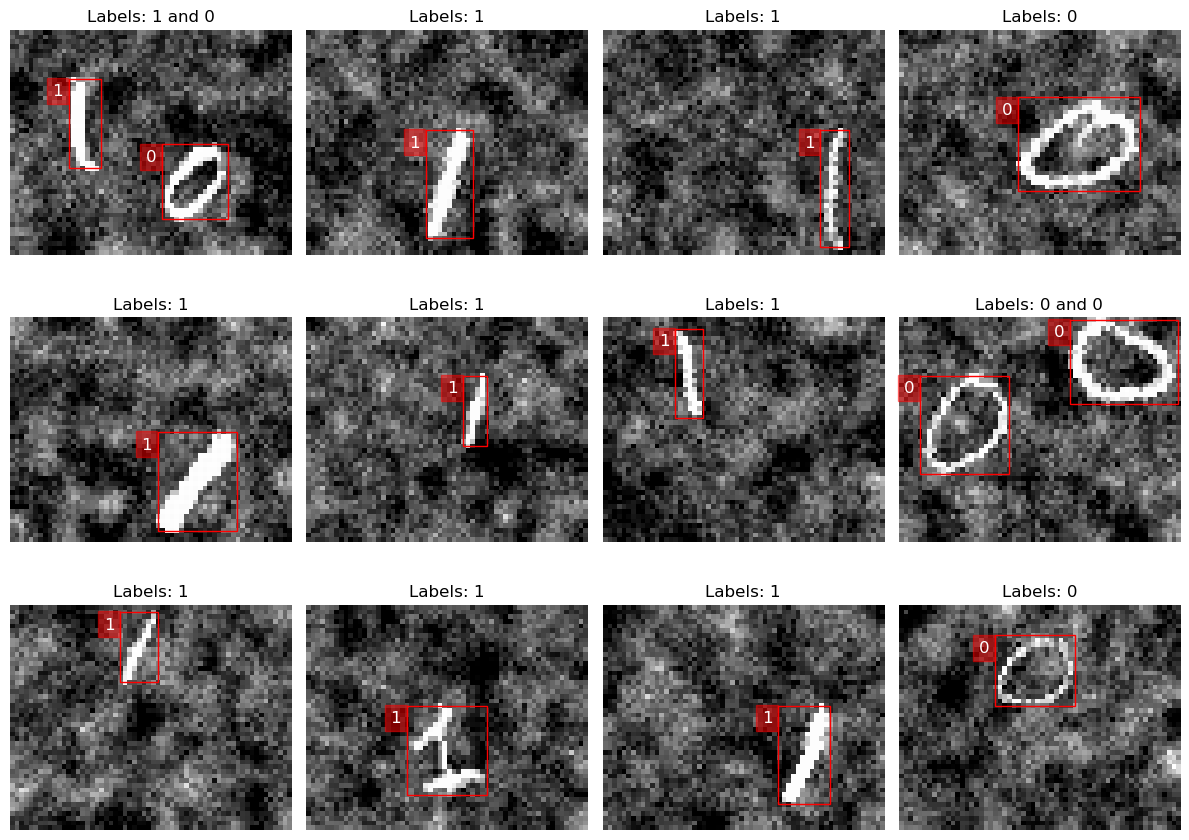

In [20]:
def plot_images_with_bboxes(dataset, num_images, grid_dims=None):

    #Original width and height divided by wout and hout
    wid = 20 
    hei = 24
    grid_rows, grid_cols = grid_dims
    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 3))
    axs = axs.flatten() 


    for idx in range(min(num_images, len(dataset))):
        image, bboxes = dataset[idx]
        axs[idx].imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
        axs[idx].axis('off') 

        classes = []
        for i, list_y in enumerate(bboxes):
            for j, y_true in enumerate(list_y):
                if y_true[0] == 1:  #If the bounding box is valid
                    x_center, y_center, w, h = y_true[1] * wid, y_true[2] * hei, y_true[3] * wid, y_true[4] * hei
                    x, y = (x_center - w / 2) + (wid*j), (y_center - h / 2)+ (hei*i)
                    
                    #Draw the bounding box with labeled class
                    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
                    axs[idx].add_patch(rect)
                    classes.append(str(int(y_true[-1])))
                    axs[idx].text(x-3.5, y+1, str(int(y_true[-1])), color='white', fontsize=12, 
                                  va='top', ha='left', backgroundcolor=(1,0,0,0.5))
                    
        title_text = "Labels: " + " and ".join(classes) if classes else "No predictions"
        axs[idx].set_title(title_text)

    plt.tight_layout()
    plt.show()


plot_images_with_bboxes(detect_train, 12, grid_dims=[3, 4])

Normalize images based on mean and std deviation of training data

In [21]:
imgs_train = torch.cat([img for img, _ in detect_train])

normalizer = transforms.Normalize(
    imgs_train.mean(dim=(0, 1, 2)), 
    imgs_train.std(dim=(0, 1, 2))
    )

transform = transforms.Compose([
    normalizer 
])

#Normalize data
det_train_norm = [(transform(img), label) for img, label in detect_train]
det_val_norm = [(transform(img), label) for img, label in detect_val]
det_test_norm = [(transform(img), label) for img, label in detect_test]


#Rename back
detect_train = det_train_norm
detect_val= det_val_norm
detect_test = det_test_norm


Convolutional model

In [22]:
class DetectionCNN(nn.Module):
    def __init__(self, C):
        super(DetectionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        #To get the correct dimensions, we use adaptiveMaxPool2d((2,3))
        self.adaptive_pool = nn.AdaptiveMaxPool2d((2, 3))

        self.conv_final = nn.Conv2d(64, C + 5, kernel_size=1) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)  

        x = self.adaptive_pool(x)
        x = self.conv_final(x)
        output = x.permute(0, 2, 3, 1)
        return output


Loss function

In [23]:
class DetectionLoss(nn.Module):
    def __init__(self):
        super(DetectionLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        total_loss = 0.0
        
        N, Hout, Wout, _ = predictions.shape
        target_classes = targets[..., 5].long() 
        
        #Loop over each cell in the grid
        for i in range(Hout):
            for j in range(Wout):
                pred_cell = predictions[:, i, j, :]
                target_cell = targets[:, i, j, :]
                
                #Compute detection loss (LA)
                loss_a = self.bce_loss(pred_cell[:, 0], target_cell[:, 0])

                #Compute localization loss (LB) if object is present on grid cell
                loss_b = self.mse_loss(pred_cell[:, 1:5], target_cell[:, 1:5]) * (target_cell[:, 0].unsqueeze(1) > 0.5).float()
                
                #Compute classification loss (LC) if object is present on grid cell
                loss_c = self.ce_loss(pred_cell[:, 5:], target_classes[:, i, j]) * (target_cell[:, 0] > 0.5).float()
                
                #Sum the losses for this cell. To impact the model more for wrong boundary box we can multiply the loss_b.sum(1) with 2.
                #cell_loss = loss_a + loss_b.sum(1)*2 + loss_c
                
                cell_loss = loss_a + loss_b.sum(1) + loss_c
                total_loss += cell_loss.sum()
        
        #Divide by the batch size to normalize
        return total_loss / N

Training and evaluation functions

In [24]:
#Since it was not a requirement to use mean average precision as performance measure for this task, we have decided
#to use a mix of mean IoU, classification accuracy and detection accuracy instead.
def evaluate_model_detection(model, val_loader, loss_function, device):
	model.eval()
	total_val_loss = 0.0
	total_iou = 0.0
	correct_classifications = 0
	correct_detections = 0 
	total_objects = 0

	with torch.no_grad():
		for images, targets in val_loader:
			images, targets = images.to(device), targets.to(device)
			outputs = model(images)
			loss = loss_function(outputs, targets)
			total_val_loss += loss.item() * images.size(0)

			for img_idx in range(images.size(0)):
				#Count predicted objects
				pred_objects = (outputs[img_idx, :, :, 0] > 0.5).sum().item()  
				#Count actual objects
				true_objects = (targets[img_idx, :, :, 0] > 0.5).sum().item()  

				#Check if the number of predicted objects matches the actual number
				if pred_objects == true_objects:
					correct_detections += 1
				
				#Process each grid cell
				for i in range(2):  #2 for Hout
					for j in range(3):  #3 for Wout
						cell_output = outputs[img_idx, i, j, :]
						cell_target = targets[img_idx, i, j, :]
						
						if cell_target[0].item() > 0.5:
							total_objects += 1
							if cell_output[0].item() > 0.5:
								pred_box = cell_output[1:5]
								true_box = cell_target[1:5]
								iou = bbox_iou(pred_box.unsqueeze(0), true_box.unsqueeze(0))
								total_iou += iou.item()

								_, predicted_class = cell_output[5:].max(0)
								true_class = int(cell_target[5].item())

								#Check if the predicted class is correct (same as the true class label)
								if predicted_class.item() == true_class:
									correct_classifications += 1
									
	mean_val_loss = total_val_loss / len(val_loader.dataset)
	mean_iou = total_iou / total_objects if total_objects > 0 else 0
	#Classification accuracy - the accuracy of correctly predicted labels
	classification_accuracy = correct_classifications / total_objects if total_objects > 0 else 0
	#Detection accuracy - the accuracy which the model correctly detects amount of objects
	detection_accuracy = correct_detections / len(val_loader.dataset) if len(val_loader.dataset) > 0 else 0
	
	return mean_val_loss, mean_iou, classification_accuracy, detection_accuracy


def train_one_epoch(model, train_loader, loss_function, optimizer, device):
	model.train()
	total_loss = 0.0
	total_objects = 0

	for images, targets in train_loader:
		images, targets = images.to(device), targets.to(device)

		optimizer.zero_grad()
		outputs = model(images)
		loss = loss_function(outputs, targets)
		loss.backward()
		optimizer.step()

		total_loss += loss.item() * images.size(0)
		total_objects += images.size(0)

	mean_loss = total_loss / total_objects
	return mean_loss

#### Training 

Training several models and choosing best one based on performance on validation data

In [25]:
C = 2
train_dataset = torch.load('data\detection_train.pt')
val_dataset = torch.load('data\detection_val.pt')
test_dataset = torch.load('data\detection_test.pt')


train_loader = DataLoader(detect_train, batch_size=64, shuffle=True)  
val_loader = DataLoader(detect_val, batch_size=64, shuffle=False)
test_loader = DataLoader(detect_test, batch_size=64, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
batch_size = [32, 64, 128]

lr_list = [0.01, 0.001, 0.0005]

best_val_p = 0
best_model = None
best_batch = 0
best_lr = 0
best_v_acc = 0
best_iou = 0



###################


model = DetectionCNN(C=C)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss_function = DetectionLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_losses = []
train_losses = []

for bs in batch_size:
	for lear in lr_list:
		print(f"Training model with bach size: {bs}, and learning rate: {lear} ")
		model = DetectionCNN(C=C)
		model.to(device)	
		train_loader = torch.utils.data.DataLoader(loc_train, batch_size=bs, shuffle=True)
		optimizer = torch.optim.Adam(model.parameters(), lr=lear)
		loss_function = DetectionLoss().to(device)
		val_losses = []
		train_losses = []

		for epoch in range(num_epochs):
			train_loader = DataLoader(detect_train, batch_size=bs, shuffle=True)  
			train_loss = train_one_epoch(model, train_loader, loss_function, optimizer, device)
			train_losses.append(train_loss)
			val_loss, val_mean_iou, val_accuracy, detect_accuracy = evaluate_model_detection(model, val_loader, loss_function, device)
			val_losses.append(val_loss)
			print(f'Epoch [{epoch+1}/{num_epochs}], '
			  	f'Train Loss: {train_loss:.4f}, '
			  	f'Val Loss: {val_loss:.4f}, '
			  	f'Val Accuracy: {val_accuracy:.4f}, '
			  	f'Detection accuracy: {detect_accuracy:.4f}, '
			  	f'Mean IoU: {val_mean_iou}')
		
		val_per = (val_mean_iou+ val_accuracy +detect_accuracy)/3 
		if val_per > best_val_p:
			best_batch = bs
			best_lr = learning_rate
			best_v_acc = val_accuracy
			best_iou = val_mean_iou
			best_val_p = val_per
			best_v_losses = val_losses
			best_t_losses = train_losses
			best_model = model

print(f"Final best model is a model with bach size: {best_batch}, and learning rate: {best_lr} ")
print()
print(f"Best model: validation accuracy:{best_v_acc:.2f} , validation iou: {best_iou:.2f} and  mean performance: {best_val_p:.2f}")


Training model with bach size: 32, and learning rate: 0.01 
Epoch [1/15], Train Loss: 1.6081, Val Loss: 1.0881, Val Accuracy: 0.7580, Detection accuracy: 0.7159, Mean IoU: 0.4320639262437182
Epoch [2/15], Train Loss: 1.1120, Val Loss: 0.9840, Val Accuracy: 0.7847, Detection accuracy: 0.7371, Mean IoU: 0.46085428741761797
Epoch [3/15], Train Loss: 1.0108, Val Loss: 1.0248, Val Accuracy: 0.7098, Detection accuracy: 0.6785, Mean IoU: 0.38251435659337074
Epoch [4/15], Train Loss: 0.9482, Val Loss: 0.9229, Val Accuracy: 0.7301, Detection accuracy: 0.6913, Mean IoU: 0.4020402712655195
Epoch [5/15], Train Loss: 0.9080, Val Loss: 0.8958, Val Accuracy: 0.8217, Detection accuracy: 0.7836, Mean IoU: 0.5007761270166879
Epoch [6/15], Train Loss: 0.8858, Val Loss: 1.0150, Val Accuracy: 0.6699, Detection accuracy: 0.6320, Mean IoU: 0.4076466871373146
Epoch [7/15], Train Loss: 0.8696, Val Loss: 0.8505, Val Accuracy: 0.8163, Detection accuracy: 0.7776, Mean IoU: 0.4305835944581702
Epoch [8/15], Train L

Plot loss graphs for best chosen model

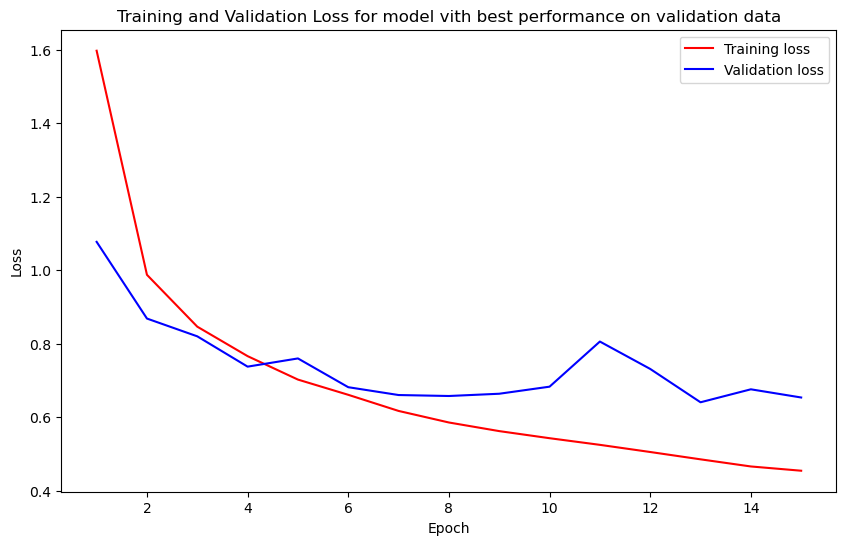

In [26]:
#Plotting losses of best model
plt.figure(figsize=(10, 6))
epochs_plot = range(1, len(train_losses) + 1)
plt.plot(epochs_plot, best_t_losses, 'r-', label='Training loss')
plt.plot(epochs_plot, best_v_losses, 'b-', label='Validation loss')
plt.title('Training and Validation Loss for model vith best performance on validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Function for plotting predicted images

In [27]:
def plot_images_with_boxes(model, data_loader, class_labels, num_images=5):
    model.eval()
    device = next(model.parameters()).device

    img_height, img_width = 48, 60
    #Calculate the number of rows and columns for plotting multiple images on multiple rows, max 6 per row
    num_cols = min(num_images, 6)  
    num_rows = np.ceil(num_images / num_cols).astype(int)  
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 3.3)) 
    if num_images == 1:
        axs = np.array([[axs]])  
    elif num_rows == 1:
        axs = np.array([axs]) 

    plotted_images = 0
    for images, labels in data_loader:
        if plotted_images >= num_images:
            break

        images = images.to(device)
        outputs = model(images)

        for img_idx in range(images.shape[0]):
            if plotted_images >= num_images:
                break

            row = plotted_images // num_cols
            col = plotted_images % num_cols
            

            t_classes = []
            p_classes = []

            ax = axs[row, col] if num_rows > 1 else axs[0, col]  
            img = images[img_idx].cpu().numpy().squeeze()  
            ax.imshow(img, cmap='gray')

            for i in range(2):  #Hout
                for j in range(3):  #Wout
                    cell_output = outputs[img_idx, i, j, :]
                    cell_label = labels[img_idx, i, j, :]
                    if cell_label[0].item() > 0.5: 
                        #True bounding box
                        x, y, w, h = cell_label[1:5].tolist()
                        abs_x, abs_y = x * img_width / 3 + j * img_width / 3, y * img_height / 2 + i * img_height / 2
                        abs_w, abs_h = w * img_width / 3, h * img_height / 2
                        rect_true = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2), abs_w, abs_h, linewidth=2, edgecolor='green', facecolor='none', label='True BB')
                        ax.add_patch(rect_true)

                        #True class label
                        true_class_index = int(cell_label[5].item())
                        true_class_label = class_labels[true_class_index]
                        t_classes.append(str(int(true_class_label)))
                        ax.text(abs_x, abs_y, str(int(true_class_label)), color='white', fontsize=12, 
                                  va='top', ha='left', backgroundcolor=(0,1,0,0.5))

                    if cell_output[0].item() > 0.5:  #If model predicts an object
                        #Predicted bounding box
                        x, y, w, h = cell_output[1:5].tolist()
                        abs_x, abs_y = x * img_width / 3 + j * img_width / 3, y * img_height / 2 + i * img_height / 2
                        abs_w, abs_h = w * img_width / 3, h * img_height / 2
                        


                        rect_pred = patches.Rectangle((abs_x - abs_w / 2, abs_y - abs_h / 2), abs_w, abs_h, linewidth=2, edgecolor='red', facecolor='none', label='Pred BB')
                        ax.add_patch(rect_pred)

                        #Predicted class label
                        pred_class_index = cell_output[5:].argmax().item()
                        pred_class_label = class_labels[pred_class_index]
                        p_classes.append(str(int(pred_class_label)))
                        ax.text(abs_x, abs_y, str(int(pred_class_label)), color='white', fontsize=12, 
                                  va='top', ha='left', backgroundcolor=(1,0,0,0.5))

            ax.axis('off')
            true_title_text = "True Labels: " + " and ".join(t_classes) if t_classes else "No predictions"
            pred_title_text = "Predicted Labels: " + " and ".join(p_classes) if p_classes else "No predictions"
            
            title_text = true_title_text+'\n'+pred_title_text
            ax.set_title(title_text)
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.0), ncol=2)
            plotted_images += 1
    for idx in range(plotted_images, num_rows * num_cols):
        fig.delaxes(axs.flatten()[idx])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.7)
    plt.show()

Plot predictions from validation and traning datasets

Best model train accuracy: 0.91 , train iou: 0.53 , train detection accuracy: 0.88 and train mean performance: 0.77


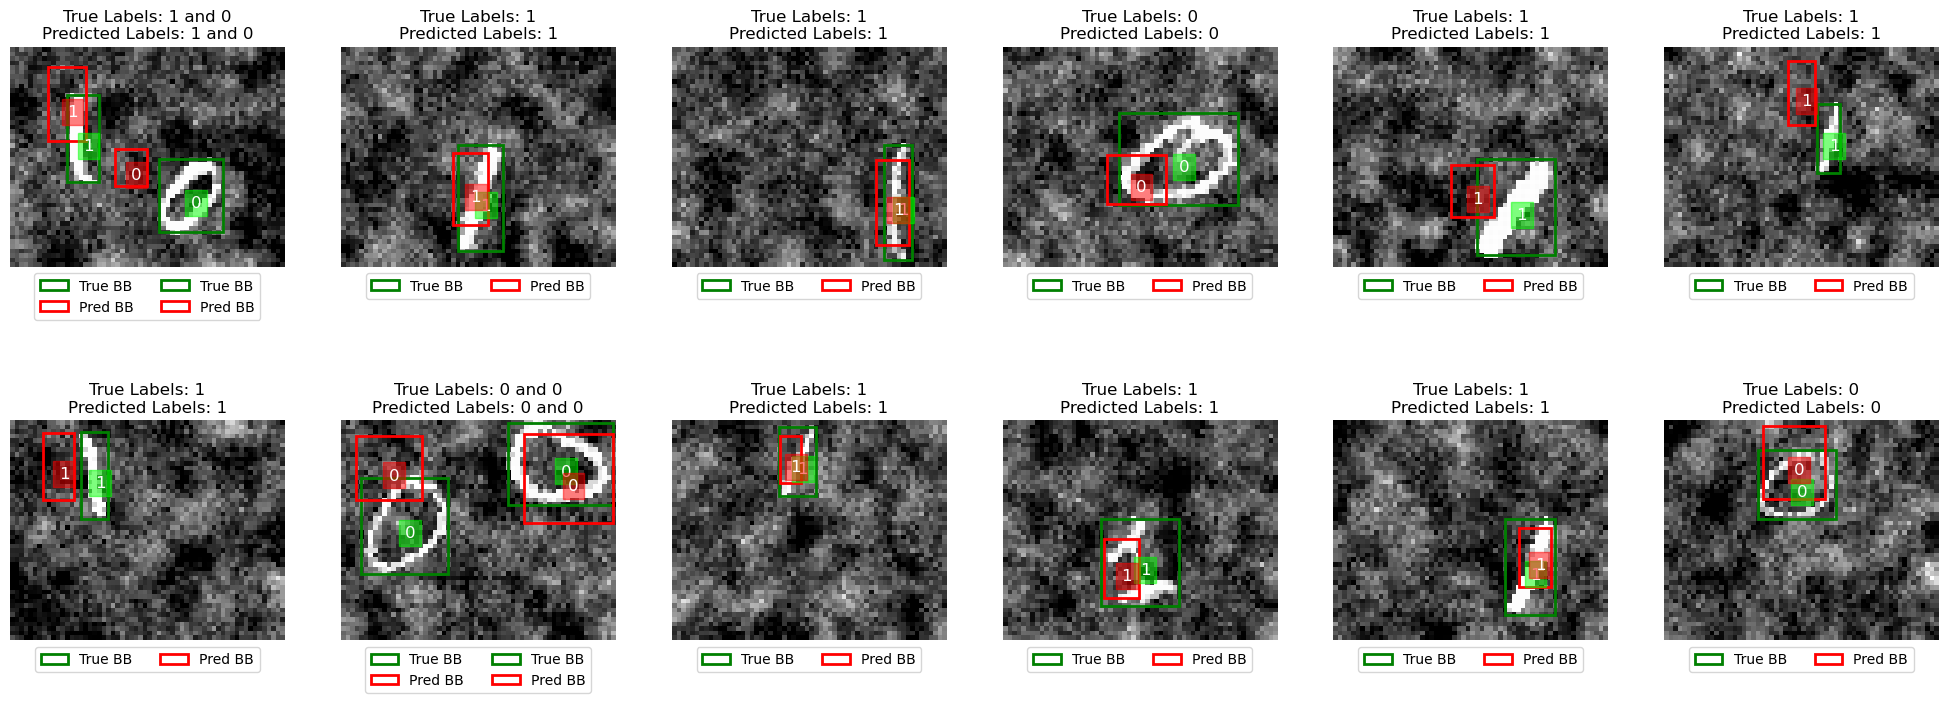

In [28]:
#Evaluate the model on training
train_loader = torch.utils.data.DataLoader(detect_train, batch_size=1, shuffle=False)

_, train_mean_iou, train_accuracy, train_detect_accuracy = evaluate_model_detection(best_model, train_loader, loss_function, device)

train_p = (train_mean_iou+train_accuracy+train_detect_accuracy)/3


print(f"Best model train accuracy: {train_accuracy:.2f} , train iou: {train_mean_iou:.2f} , train detection accuracy: {train_detect_accuracy:.2f} and train mean performance: {train_p:.2f}")


plot_images_with_boxes(best_model, train_loader, [0,1], num_images=12)

Best model validation accuracy: 0.87 , validation iou: 0.51 , validation detection accuracy: 0.83 and validation mean performance: 0.74


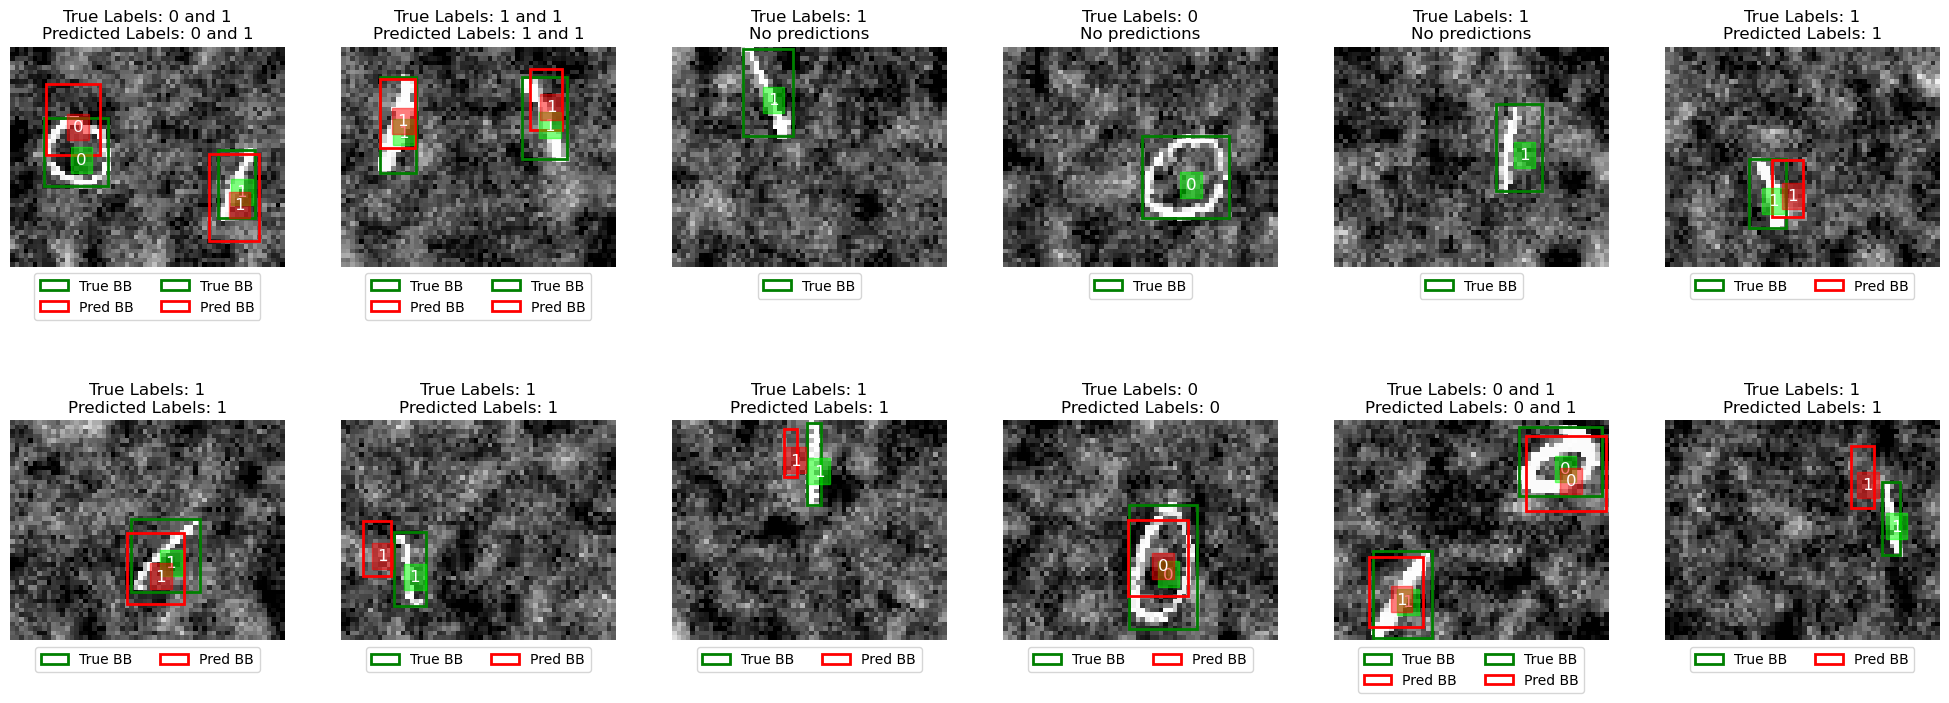

In [29]:
#Evaluate the model on validation
val_loader = torch.utils.data.DataLoader(detect_val, batch_size=1, shuffle=False)

_, val_mean_iou, val_accuracy, val_detect_accuracy = evaluate_model_detection(best_model, val_loader, loss_function, device)

val_p = (val_mean_iou+ val_accuracy+ val_detect_accuracy)/3

print(f"Best model validation accuracy: {val_accuracy:.2f} , validation iou: {val_mean_iou:.2f} , validation detection accuracy: {val_detect_accuracy:.2f} and validation mean performance: {val_p:.2f}")


plot_images_with_boxes(best_model, val_loader, [0,1], num_images=12)

Finally we test our best model on test data and plot some results

Best model test accuracy: 0.87 , test iou: 0.51 , test detection accuracy: 0.83 and test mean performance: 0.74


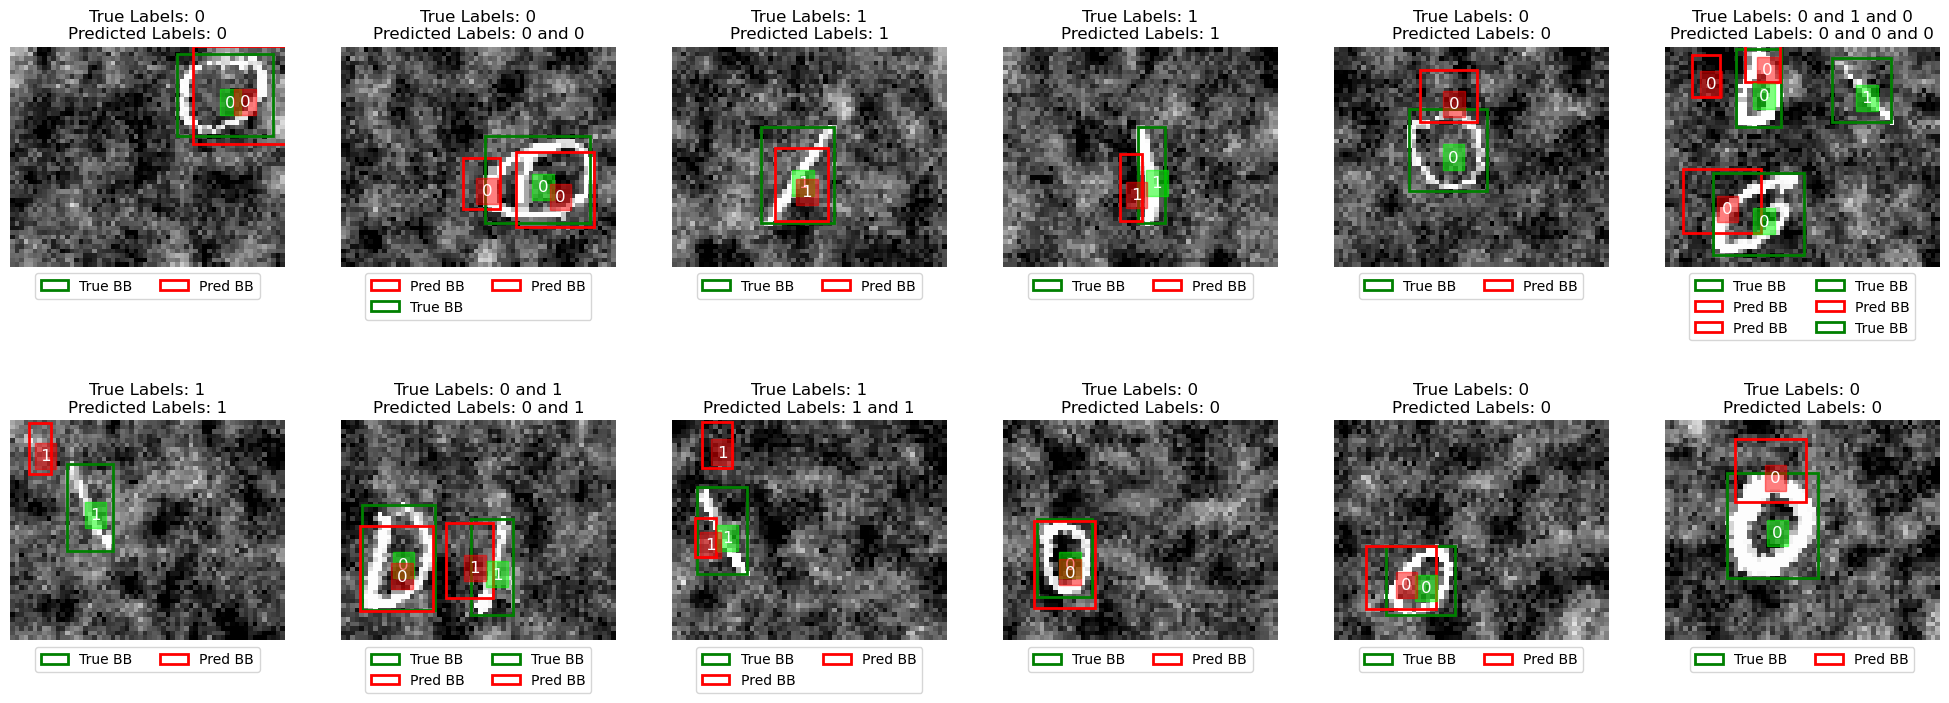

In [30]:
#Evaluate the model on validation
test_loader = torch.utils.data.DataLoader(detect_test, batch_size=1, shuffle=False)

_, test_mean_iou, test_accuracy, test_detect_accuracy = evaluate_model_detection(best_model, test_loader, loss_function, device)
test_p = (test_mean_iou + test_accuracy + test_detect_accuracy) / 3

print(f"Best model test accuracy: {test_accuracy:.2f} , test iou: {test_mean_iou:.2f} , test detection accuracy: {test_detect_accuracy:.2f} and test mean performance: {test_p:.2f}")

plot_images_with_boxes(best_model, test_loader, [0,1], num_images=12)